In [1]:
import xarray as xr
import rioxarray
import pandas as pd
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from einops import rearrange


import cv2

root = Path.cwd()

In [54]:
epsg = 26919
site_name = 'BART'
year = '2019'

b = xr.open_dataarray(root / 'sentinel_data' / f'{year}_{site_name}.nc')
b = b.rio.write_crs(epsg).rio.set_spatial_dims(x_dim="x",y_dim="y",).rio.write_coordinate_system()

### Image Coregistration

In [92]:
def get_gradient(im) :
# Calculate the x and y gradients using Sobel operator
    grad_x = cv2.Sobel(im,cv2.CV_32F,1,0,ksize=3)
    grad_y = cv2.Sobel(im,cv2.CV_32F,0,1,ksize=3)
    
    # Combine the two gradients
    grad = cv2.addWeighted(np.absolute(grad_x), 0.5, np.absolute(grad_y), 0.5, 0)
    return grad

In [233]:
# create reference image: mean of all temporal steps
reference_image = b.mean(dim=['band','time'])
reference_image = reference_image.where(~np.isnan(reference_image), other=0)

# images to be co-registered
b_sel = b.isel(time=[6,7,14,15,16,19,20,21])
b_sel = b_sel.where(~np.isnan(b_sel), other=0)

# single rgb to be co-registered
# april_vis = b_sel.isel(band=slice(0,3),time=1)
# april_vis = april_vis.where(~np.isnan(april_vis), other=0)

In [ ]:
# loop over time and apply coregistration to each band
height = b_sel.shape[2]
width = b_sel.shape[3]
time = b_sel.shape[0]
band = b_sel.shape[1]

## Define motion model
warp_mode = cv2.MOTION_AFFINE
# Set the warp matrix to identity matrix
warp_matrix = np.eye(2, 3, dtype=np.float32)
# Set the stopping criteria for the algorithm.
criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 5000,  1e-10)


# convert input data to numpy float32 numpy arrays
reference_image = np.float32(reference_image.to_numpy())
im = np.float32(b_sel.to_numpy())

# Create empty array of correct size for new aligned images
im_aligned = np.zeros((time,band,height,width), dtype=np.float32 )

# Warp the image to reference image
for i in range(0,time):
    for j in range(0,band) :
        (cc, warp_matrix) = cv2.findTransformECC(get_gradient(reference_image), get_gradient(im[i,j,:,:]),warp_matrix, warp_mode, criteria)    
                                                
                                                
        im_aligned[i,j,:,:] = cv2.warpAffine(im[i,j,:,:], warp_matrix, (width,height), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
        print(warp_matrix)


In [ ]:
b_align = xr.DataArray(im_aligned, 
                      coords={'time':b_sel.time,'band': b_sel.band,'y': b_sel.y,'x':b_sel.x}, 
                      dims=['time','band','y','x'])
b_align = b_align.where(b_align!=0, other=np.nan) # reset 0 values to na
b_align.to_netcdf(root / 'sentinel_data' / '2019_bart_coreg.nc')

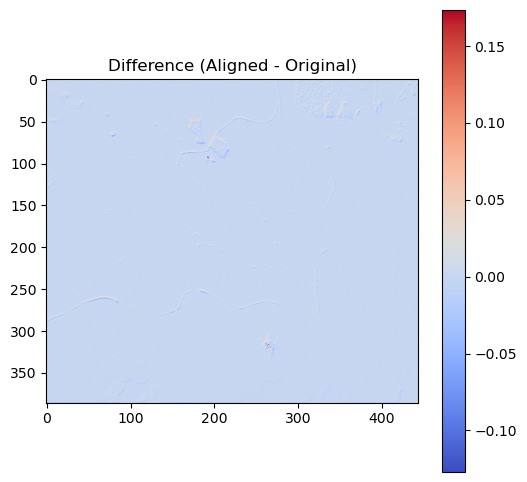

In [237]:
# Visualize the difference between aligned and original images
difference = im_aligned[1,0,:,:] - im[1,0,:,:]

plt.figure(figsize=(6, 6))
plt.imshow(difference, cmap='coolwarm')
plt.title("Difference (Aligned - Original)")
plt.colorbar()
plt.show()


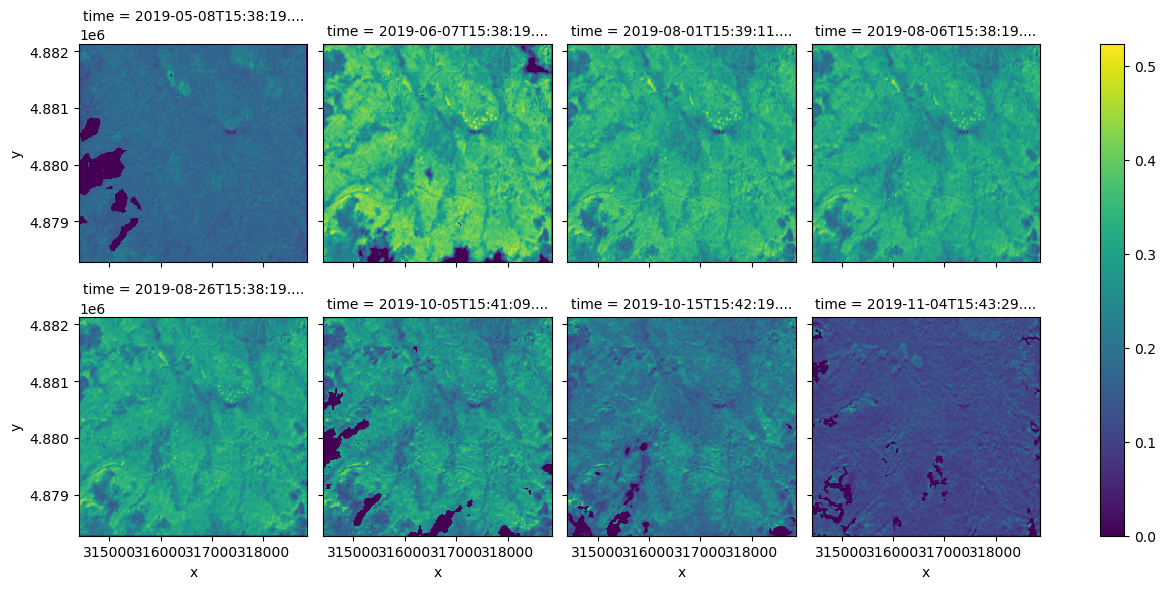

In [247]:
b_align.isel(band=4).plot(col='time',col_wrap=4)

### Get seasonal features

In [252]:
# get median seasonal values, drop time dimension, add prefix to band names
def get_season_image(a,season,indices,num_months):
    a = a.isel(time=slice(indices[0],indices[1])).resample(time=num_months).median()
    a = a.squeeze('time').reset_coords('time',drop=True)
    
    return a.assign_coords({'band':[f'{x}_{season}' for x in a.band.values]})

spring = get_season_image(a=b_align, season='spring', indices=[0,2],num_months='2MS')
summer = get_season_image(a=b_align, season='summer', indices=[2,5],num_months='3MS')
fall = get_season_image(a=b_align, season='fall', indices=[5,8],num_months='3MS')


In [254]:
season_bands = xr.concat([spring,summer,fall],dim='band')

In [255]:
# calculate seasonal evi, lswi, slavi, psri

def remove_outliers(a,norm=True):
    a = a.where(np.isfinite(a),np.nan)
    if norm == True:
        a = a.where((a >= -1) & (a <= 1))
    else:
        a = a.where((a >= 0) & (a <= 8))
    return a

array_list = [spring,summer,fall]
season_list = ['spring','summer','fall']
to_concat = list()
for i in range(0,3):
    blue = array_list[i].sel(band=f'B02_{season_list[i]}')
    red = array_list[i].sel(band=f'B04_{season_list[i]}')
    nir = array_list[i].sel(band=f'B8A_{season_list[i]}')
    sw1 = array_list[i].sel(band=f'B11_{season_list[i]}')
    sw2 = array_list[i].sel(band=f'B12_{season_list[i]}')
    re2 = array_list[i].sel(band=f'B06_{season_list[i]}')


    evi = 2.5 * ((nir - red) / (nir + 6 * red - 7.5 * blue + 1)).expand_dims({'band':[f'evi_{season_list[i]}']}) # range -1 - 1
    evi = remove_outliers(evi)

    lswi = (nir - sw1)/(nir + sw1).expand_dims({'band':[f'lswi_{season_list[i]}']}) # range -1 to 1
    lswi = remove_outliers(lswi)

    slavi = nir/(red + sw2).expand_dims({'band':[f'slavi_{season_list[i]}']}) # range 0 - 8
    slavi = remove_outliers(slavi,norm=False)

    psri = (red - blue)/re2.expand_dims({'band':[f'psri_{season_list[i]}']}) # range -1 to 1
    psri = remove_outliers(psri)

    season_vi = xr.concat([evi,lswi,slavi,psri],dim='band')

    to_concat.append(season_vi)

r = xr.concat(to_concat,dim='band')


In [256]:
# summer - fall & summer - spring for evi, lswi, slavi, and psri
def get_season_differences(band,season):
    d = r.sel(band=f'{band}_summer') - r.sel(band=f'{band}_{season}')
    return d.expand_dims({'band':[f'{band}_{season}_diff']})

to_concat = list()
for vi in ['evi', 'lswi', 'slavi','psri']:
    for s in ['spring','fall']:
        t = get_season_differences(vi,s)
        to_concat.append(t)

m1 = xr.concat(to_concat,dim='band')


In [257]:
final = xr.concat([season_bands,m1,r],dim='band')

In [258]:
final.to_netcdf(root / 'sentinel_data' / 'bartlett_stack_coreg.nc')

In [19]:
# to do: 
    # PCA on final stack
    # mnf transformation
    # select endmembers (pixels with highest beech basal area)
    # check endmembers using ppi
    # mtmf


In [150]:
# one method of normalizing sentinel images: https://forum.sentinel-hub.com/t/normalization-of-sentinel-data-for-ml-downstream/5459/6
# ndata_cutoff = np.clip(ndata/10000, 0, 0.3)  # divide with 10000 and cut of to range [0.0, 0.3]
# ndata_normalized = ndata_cutoff/0.3  # stretch to [0.0, 1.0]

### PCA

In [ ]:
# read in data
#x1 = xr.open_dataset(root / 'sentinel_data' / 'bartlett_stack.nc')
x = final
a = final.values

# a = im_aligned
# shape 3d array to 2d array
#a_2d = a.reshape((a.shape[1]*a.shape[2]),a.shape[0])
a_2d = rearrange(a, 'c h w -> (h w) c')
# drop all na from data
a2d_dropna = a_2d[~np.isnan(a_2d).any(axis=1)]
# get indices of dropped nas to replace them later
na_indices = np.where(np.isnan(a_2d))
row_indices = np.unique(na_indices[0]) # indices of rows that were dropped from a_2d

# rescale data around approximate mean of 0
scaler = StandardScaler()
data_scaled = scaler.fit_transform(a2d_dropna)

n = 3
pca = PCA(n_components=n)
#pca_data = pca.fit_transform(data_scaled)

pca.fit(data_scaled)
pca_data = pca.transform(data_scaled)
    
# replace nans that were dropped earlier
pca_data = np.insert(pca_data, row_indices, np.nan, axis=0)
# reshape to original dimensions

new_pca_data = rearrange(pca_data, '(h w) c -> h w c', h=386, w=444)
pca_array = xr.DataArray(new_pca_data, 
                      coords={'y': x.y, 'x': x.x,'pca_component': np.arange(0,n),}, 
                      dims=['y','x','pca_component'])




In [277]:
pca_array.to_netcdf(root / 'sentinel_data' / 'bartlett_pca.nc')

In [265]:
pca.explained_variance_ratio_

array([0.44141603, 0.21733256, 0.11783068], dtype=float32)

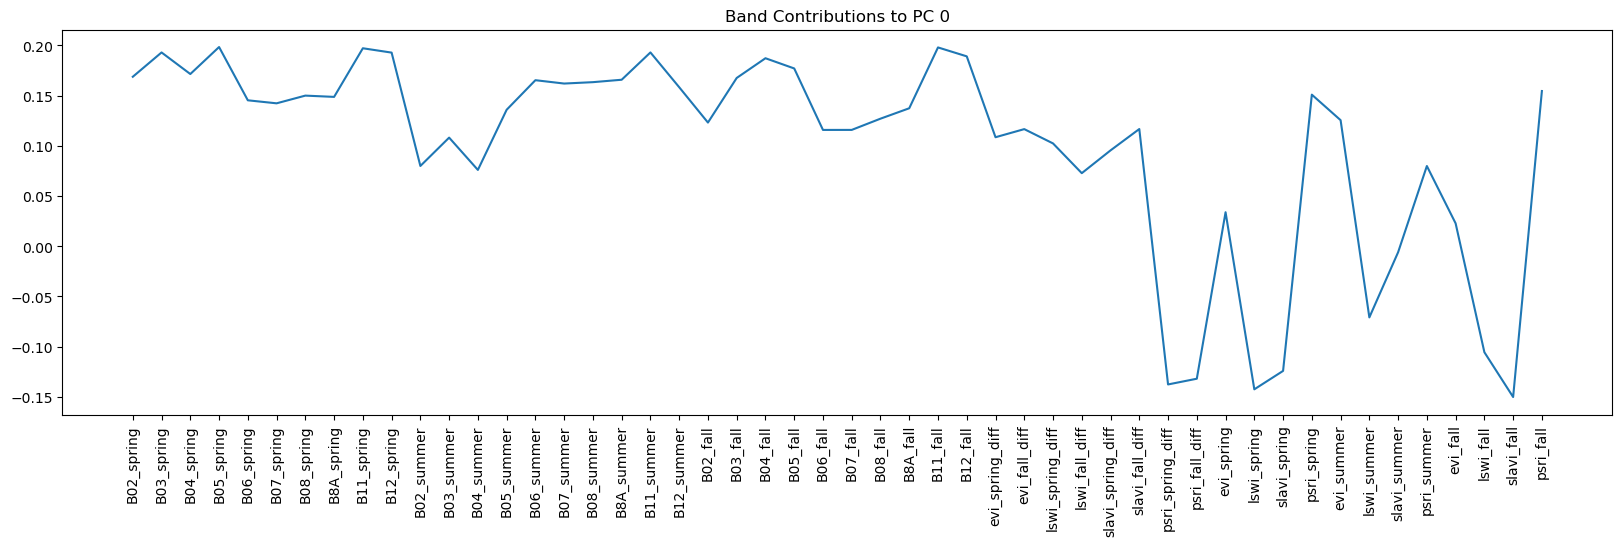

In [288]:
fig,ax = plt.subplots(figsize=(20,5))
plt.plot(final.band.values,pca.components_[0])
ax.tick_params(axis='x', labelrotation=90)
plt.title('Band Contributions to PC 0')

plt.show()

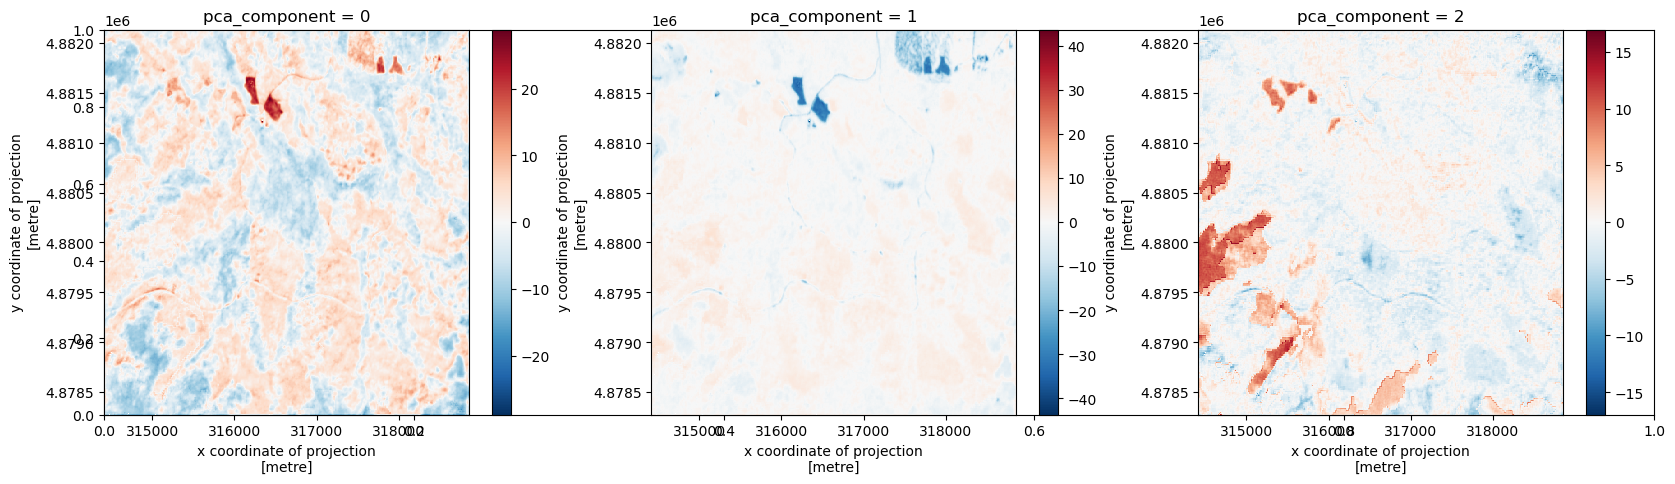

In [274]:
fig = plt.subplots(figsize=(20,5))

for i in range(0,3):
    plt.subplot(1, 3, i+1)
    pca_array.isel(pca_component=i).plot()


plt.show()

### Minimum Noise Fraction

In [2]:

pca = xr.open_dataarray(root / 'sentinel_data' / 'bartlett_pca.nc')
pca = pca.rename({'pca_component':'band'})
stack = xr.open_dataarray(root / 'sentinel_data' / 'bartlett_stack_coreg.nc')

In [ ]:
# combine bands we want
s = xr.concat([pca,stack.sel(band=[x for x in stack.band.values if x.endswith('spring') & x.startswith('B')]), stack.sel(band=[x for x  in stack.band.values if 'diff' in x ]) ],dim='band')

In [57]:
M = s.values
M.shape

(386, 444, 21)

In [58]:
# convert to 2d
M = rearrange(M, 'h w c -> (h w) c')
M.shape

(171384, 21)

In [59]:
# impute nans
imputer = SimpleImputer(strategy='mean')
M = imputer.fit_transform(M)

np.isnan(M).sum()

np.int64(0)

In [43]:
# get covariance matrix
N = M.shape[0]
u = M.mean(axis=0)
M = M - np.kron(np.ones((N, 1)), u)  # subtract column means from each element (np.kron makes a matrix containing means)
C = np.dot(M.T, M) / (N-1)

# gives same result as:
#B = np.cov(M,rowvar=False)

In [62]:
# whiten
sigma = C
U,S,V = np.linalg.svd(sigma)  # U,V = eigenvectors of sigma; S = eigenvalues
S_1_2 = S**(-0.5)    # reciprocal square root i.e. 1/sqrt(S) scales eigenvalues
S = np.diag(S_1_2.T)  # create diagonal matrix
Aw = np.dot(V, np.dot(S, V.T))   # compute whitening transformation matrix
dM = np.dot(M, Aw)   # apply whitening - all features are uncorrelated and have variance of 1

In [52]:
# pca
transform = PCA()
mnf = transform.fit_transform(dM)
# reshape back to 3d
mnf = rearrange(mnf,'(h w) c -> h w c', h=386, w=444)

In [ ]:
p = xr.open_dataset(root / 'output' / 'BART' / 'percent_basal_area_BART.nc')['percent_beech_basal_area']



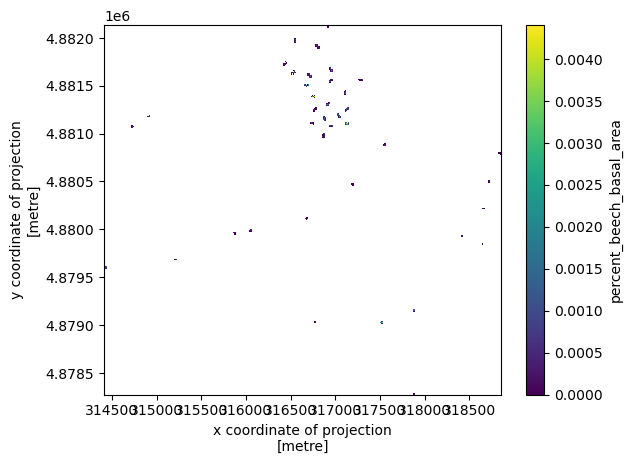

In [142]:
p.plot()

In [143]:

# stacked = h.stack(notnull=['x','y']) 

# pixels = stacked[stacked.notnull()].coords.to_index().values
# pixels = [(int(c[0]),int(c[1])) for c in pixels]


In [200]:
h = p.where(p > 0.0030)
h = h.values

rows, cols = np.where(~np.isnan(h))

pixels = [(int(row),int(col)) for row,col in zip(rows,cols)]
len(pixels)

5

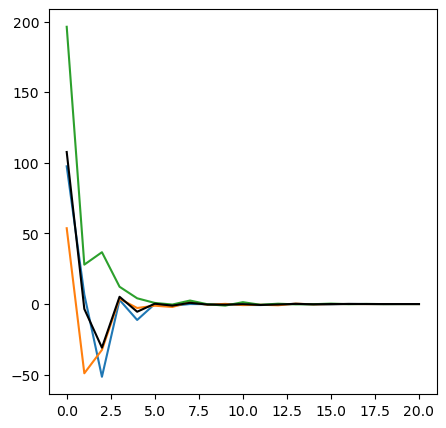

In [206]:


#h.shape = (y,x), mnf.shape = (y,x,b), y=rows(height), x=columns(width), 
p_list = []

for i in range(0,len(pixels)):
    p_list.append(mnf[pixels[i][0],pixels[i][1],:])

p_m = np.array(p_list[1:])

p_mean = np.mean(p_m,axis=0)

fig,ax = plt.subplots(figsize=(5,5))

for i in range(1,p_m.shape[0]):
    plt.plot(p_m[i])

plt.plot(p_mean,color='black')

plt.show()

### MTMF

In [ ]:
y={(mu_t-mu_b)^TSigma^{-1}(x-mu_b)}/{(mu_t-mu_b)^TSigma^{-1}(mu_t-mu_b)}

In [207]:
reshaped_data = rearrange(mnf,'h w c -> (h w) c')
reshaped_data.shape

(171384, 21)

In [208]:
# Target spectral signature # pixel with lots of beech trees
target = p_mean
# background mean (mu_b) as the mean spectrum of the image
u_b = np.mean(mnf, axis=(0, 1))  # Average over rows and cols
# difference between target and background mean
d_tb = (target- u_b)

# Calculate the covariance matrix of the background
reshaped_data = rearrange(mnf,'h w c -> (h w) c')  # Reshape to (pixels, bands)
C = np.cov(reshaped_data, rowvar=False)  # Covariance matrix (bands x bands)
# Calculate the inverse of the covariance matrix
C1 = np.linalg.inv(C)

 # Normalization coefficient (inverse of  squared Mahalanobis distance
# between u_t and u_b)
coef = 1.0 / d_tb.dot(C1).dot(d_tb)

# 2d array input
X = reshaped_data
A = (coef * d_tb).dot(C1) #transform method 
Y = np.dot(A, X.T).T


In [ ]:
shape= mnf.shape
r = Y.reshape((shape[0],shape[1]) + (-1,)).squeeze()

In [232]:
out = xr.DataArray(r, 
                      coords={'y': s.y, 'x': s.x}, 
                      dims=['y','x'])

In [241]:
out_clip = out.where((out > -5) & (out < 5))

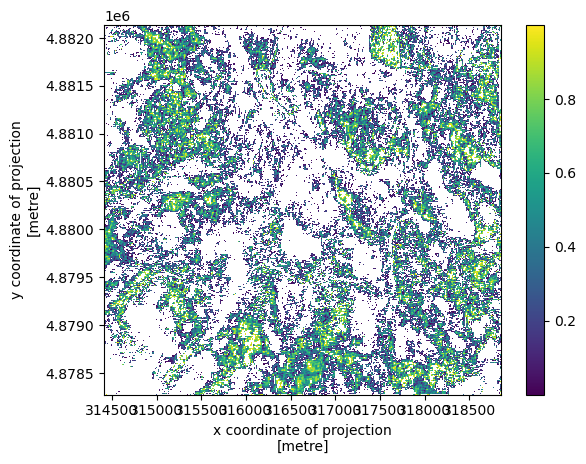

In [243]:
out_clip2 = out.where((out >=0) & (out <=1))
out_clip2.plot()

In [244]:
out_clip2.to_netcdf(root / 'output' / 'BART' / 'bartlett_mtmf_clipped0to1.nc')

In [214]:
# Precompute reusable terms
#mu_diff = mu_t - mu_b  # Difference between target and background mean
# numerator_constant = mu_diff.T @ Sigma_inv  # Precompute (mu_t - mu_b)^T Sigma^-1
# denominator = mu_diff.T @ Sigma_inv @ mu_diff  # Precompute denominator

# Initialize output array for matched filtering scores
#mf_scores = np.zeros((reshaped_data.shape[0], reshaped_data.shape[1]))


# Vectorized implementation
x_diff = reshaped_data - u_b  # Subtract background mean from all pixels (pixels x bands)
numerator = x_diff @ C1 @ d_tb  # Compute the numerator for all pixels
denominator = d_tb.T @ C1 @ d_tb  # Precompute denominator
mf_scores_vectorized = numerator.reshape(reshaped_data.shape[0], reshaped_data.shape[1]) / denominator  # Reshape to image dimensions

ValueError: cannot reshape array of size 171384 into shape (171384,21)

In [ ]:




def cov(M):
    """
    Compute the sample covariance matrix of a 2D matrix.

    Parameters:
      M: `numpy array`
        2d matrix of HSI data (N x p)

    Returns: `numpy array`
        sample covariance matrix
    """
    N = M.shape[0]
    u = M.mean(axis=0)
    M = M - np.kron(np.ones((N, 1)), u)
    C = np.dot(M.T, M) / (N-1)
    return C



def whiten(M):
    """
    Whitens a HSI cube. Use the noise covariance matrix to decorrelate
    and rescale the noise in the data (noise whitening).
    Results in transformed data in which the noise has unit variance
    and no band-to-band correlations.

    Parameters:
        M: `numpy array`
            2d matrix of HSI data (N x p).

    Returns: `numpy array`
        Whitened HSI data (N x p).

    Reference:
        Krizhevsky, Alex, Learning Multiple Layers of Features from
        Tiny Images, MSc thesis, University of Toronto, 2009.
        See Appendix A.
    """
    sigma = util.cov(M)
    U,S,V = np.linalg.svd(sigma)
    S_1_2 = S**(-0.5)
    S = np.diag(S_1_2.T)
    Aw = np.dot(V, np.dot(S, V.T))
    return np.dot(M, Aw)


class Whiten(object):
    """Whiten the cube."""

    def __init__(self):
        self.dM = None

    @ApplyInputValidation('Whiten')
    def apply(self, M):
        """
        Whitens a HSI cube. Use the noise covariance matrix to decorrelate
        and rescale the noise in the data (noise whitening).
        Results in transformed data in which the noise has unit variance
        and no band-to-band correlations.

        Parameters:
            M: `numpy array`
              A HSI cube (m x n x p).

        Returns: `numpy array`
              A whitened HSI cube (m x n x p).
        """
        h, w, numBands = M.shape
        M = np.reshape(M, (w*h, numBands))
        dM = dnoise.whiten(M)
        self.dM = np.reshape(dM, (h, w, numBands))
        return self.dM

    def get(self):
        """
        Returns: `numpy array`
            The whitened HSI cube (m x n x p).
        """
        return self.dM


class MNF(object):
    """Transform a HSI cube."""

    def __init__(self):
        self.mnf = None
        self.transform = None
        self.wdata = None # temp

    @ApplyInputValidation('MNF')
    def apply(self, M):
        """
        A linear transformation that consists of a noise whitening step
        and one PCA rotation.

        This process is designed to
            * determine the inherent dimensionality of image data,
            * segregate noise in the data,
            * allow efficient elimination and/or reduction of noise, and
            * reduce the computational requirements for subsequent processing.

        Parameters:
            M: `numpy array`
              A HSI cube (m x n x p).

        Returns: `numpy array`
              A MNF transformed cube (m x n x p).

        References:
          C-I Change and Q Du, "Interference and Noise-Adjusted Principal
          Components Analysis," IEEE TGRS, Vol 36, No 5, September 1999.
        """
        from sklearn.decomposition import PCA
        w = Whiten()
        wdata = w.apply(M)
        self.wdata = wdata #temp
        h, w, numBands = wdata.shape
        X = np.reshape(wdata, (w*h, numBands))
        self.transform = PCA()
        mnf = self.transform.fit_transform(X)
        self.mnf = np.reshape(mnf, (h, w, numBands))
        return self.mnf